In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
# import missingno as msno
from sklearn import svm, tree

In [4]:
train = pd.read_csv('train.csv')
train.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091


# EDA
Проверим пропущенные значения.

In [5]:
# msno.matrix(train)

Видим, что все пропуски встречаются вместе, так что можно просто удалить строки с пропущенными значениями.
Заодно удалим столбец с датами и повторяющиеся строчки.

In [6]:
df = train.dropna()
df = df.drop(columns=['ApplicationDate'])
print(train.shape, df.shape)
df = df.drop_duplicates()
print(train.shape, df.shape)

(11017, 36) (9986, 35)
(11017, 36) (9529, 35)


In [7]:
num_features = df.select_dtypes(include=np.number).columns.tolist()
cat_features = df.select_dtypes(include='object').columns.tolist()
num_features.remove('RiskScore')

print(num_features)
print(cat_features)

['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved']
['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


Рассмотрим данные о всех столбцах. Заметим выбросы в таргете и почистим их.

In [8]:
pd.set_option('display.max_columns', None)
df.describe()

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
count,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9.529000e+03,9.529000e+03,9529.000000,9529.000000,9529.000000,9529.000000,9.529000e+03,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9.529000e+03
mean,39.875223,131707.601952,678.223318,29757.317137,53.418827,1.568265,547.004093,0.284779,3.034841,0.981320,0.250427,0.052157,0.095603,24.005877,15.622206,5497.719593,1981.965159,1.822949e+05,6.878936e+04,10842.082135,0.783746,4.948368,17.647917,1.533819e+05,0.200161,0.199828,1068.863223,0.510345,0.513275,-3.458380e+04
std,11.595208,115989.243989,175.036220,27212.871160,24.393468,1.419023,502.780983,0.159266,1.740828,0.990333,0.144648,0.222354,0.294061,4.843561,8.654726,8491.101806,3021.471885,4.624953e+05,2.025591e+05,9383.125417,0.123648,2.205838,11.326066,4.571673e+05,0.093944,0.096018,1301.572948,0.843369,0.499850,1.437496e+06
min,18.000000,15000.000000,300.000000,1063.000000,12.000000,0.000000,13.000000,0.003674,0.000000,0.000000,0.003227,0.000000,0.000000,8.000000,1.000000,31.000000,16.000000,8.920000e+02,7.800000e+01,1250.000000,0.259301,0.000000,0.000000,1.004000e+03,0.052494,0.046445,30.008506,0.006064,0.000000,-9.999999e+06
25%,32.000000,21067.000000,550.000000,12633.000000,36.000000,0.000000,234.000000,0.159134,2.000000,0.000000,0.138390,0.000000,0.000000,21.000000,8.000000,1404.000000,532.000000,2.311100e+04,8.037000e+03,1711.333333,0.707136,3.000000,9.000000,7.303000e+03,0.120089,0.119684,374.710650,0.066347,0.000000,3.249476e+01
50%,40.000000,88998.000000,723.000000,21803.000000,48.000000,1.000000,399.000000,0.263013,3.000000,1.000000,0.228363,0.000000,0.000000,24.000000,16.000000,2986.000000,1123.000000,6.095100e+04,2.266300e+04,7371.250000,0.803587,5.000000,17.000000,2.763100e+04,0.182014,0.180283,684.613633,0.177859,1.000000,4.401980e+01
75%,48.000000,257409.000000,850.000000,37086.000000,60.000000,3.000000,687.000000,0.392255,4.000000,2.000000,0.340925,0.000000,0.000000,27.000000,23.000000,6256.000000,2297.000000,1.614410e+05,6.021600e+04,21273.666667,0.878992,6.000000,26.000000,1.237390e+05,0.264311,0.264806,1279.858303,0.638523,1.000000,6.526522e+01
max,80.000000,748508.000000,850.000000,418997.000000,120.000000,6.000000,10879.000000,0.914635,12.000000,6.000000,0.865842,1.000000,1.000000,44.000000,30.000000,222556.000000,109245.000000,1.128946e+07,8.997054e+06,25000.000000,0.996573,17.000000,57.000000,1.126117e+07,0.722497,0.833647,29634.807816,24.383046,1.000000,1.000000e+07


In [9]:
q_low = df['RiskScore'].quantile(0.01)
q_hi = df['RiskScore'].quantile(0.99)
df = df[(df['RiskScore'] < q_hi) & (df['RiskScore'] > q_low)]
df['RiskScore']

,RiskScore
0,66.176500
1,28.495737
2,34.488104
3,36.910753
4,31.347091
...,...
9994,34.037970
9995,76.185933
9996,41.213393
9997,43.699684


Построим матрицу корреляций и выбросим сильно коррелирующие признаки.

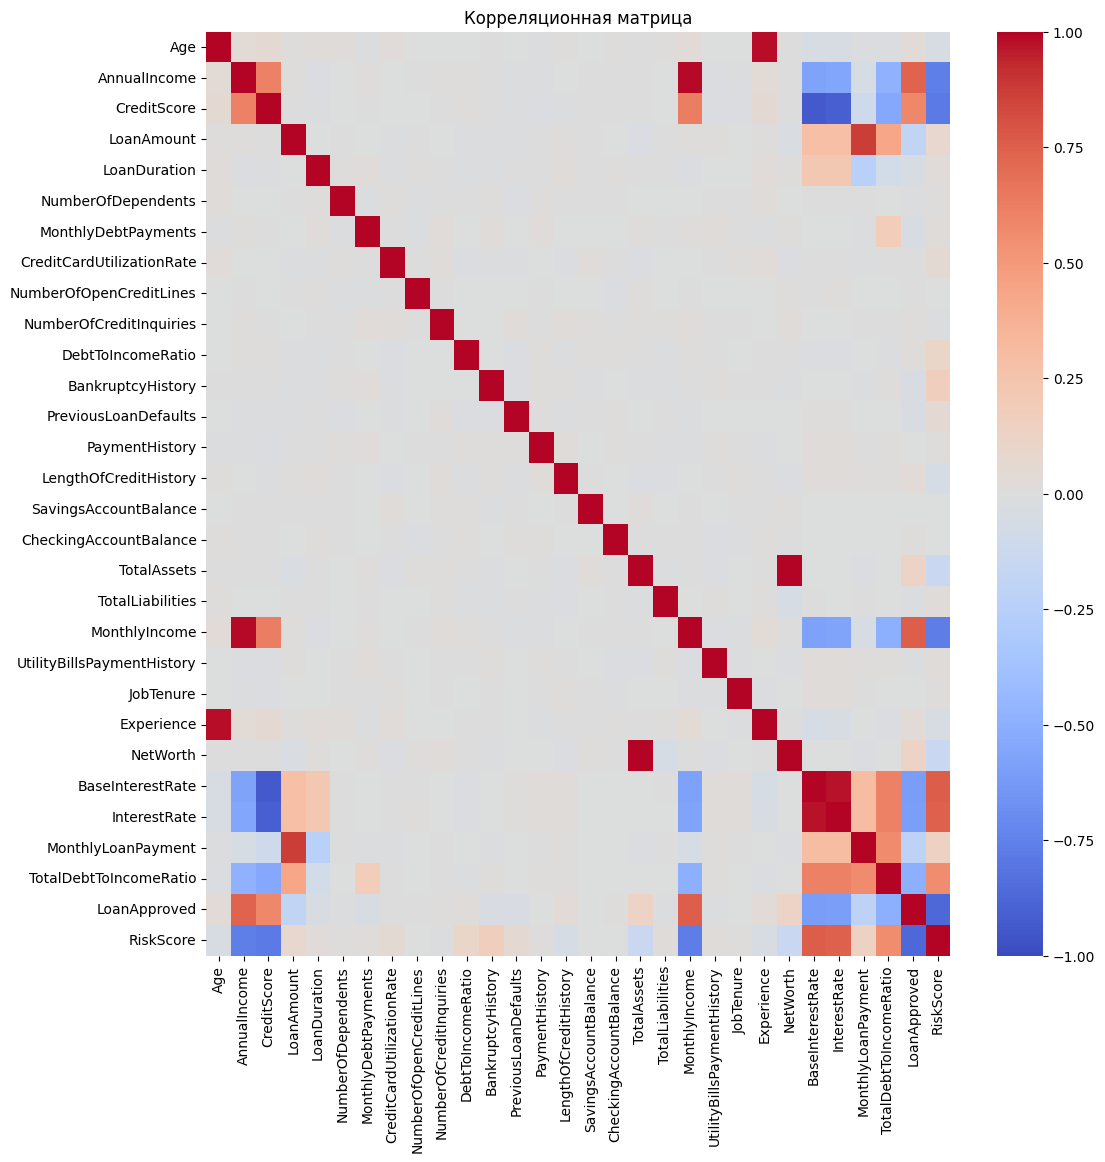

In [10]:
corr_matrix = df.select_dtypes(np.number).corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляционная матрица")
plt.show()

In [11]:
high_corr = corr_matrix[(corr_matrix >= 0.8) & (corr_matrix != 1.)].stack()
print(high_corr)

Age                 Experience            0.982768
AnnualIncome        MonthlyIncome         0.984418
LoanAmount          MonthlyLoanPayment    0.868639
TotalAssets         NetWorth              0.993821
MonthlyIncome       AnnualIncome          0.984418
Experience          Age                   0.982768
NetWorth            TotalAssets           0.993821
BaseInterestRate    InterestRate          0.975284
InterestRate        BaseInterestRate      0.975284
MonthlyLoanPayment  LoanAmount            0.868639
dtype: float64


In [12]:
df.drop(columns=['Experience', 'MonthlyIncome', 'MonthlyLoanPayment', 'NetWorth', 'BaseInterestRate'])

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,LoanPurpose,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,UtilityBillsPaymentHistory,JobTenure,EmploymentStatus,EducationLevel,InterestRate,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,0.151985,2.0,1.0,0.168542,0.0,Education,0.0,23.0,5.0,2539.0,247.0,50072.0,15005.0,0.908289,4.0,Employed,Associate,0.251465,0.288013,0.0,66.176500
1,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,0.175693,3.0,0.0,0.141553,0.0,Home,0.0,27.0,11.0,844.0,694.0,91878.0,64877.0,0.797339,2.0,Employed,High School,0.093173,0.050585,1.0,28.495737
2,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,0.444605,3.0,0.0,0.030987,1.0,Education,0.0,21.0,12.0,12756.0,651.0,292300.0,13918.0,0.915945,3.0,Employed,Bachelor,0.115443,0.072571,1.0,34.488104
3,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,0.188452,7.0,0.0,0.379843,0.0,Debt Consolidation,0.0,27.0,21.0,1524.0,529.0,13070.0,3846.0,0.876416,3.0,Employed,High School,0.112822,0.225415,1.0,36.910753
4,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,0.273431,3.0,1.0,0.068659,0.0,Debt Consolidation,0.0,35.0,9.0,1973.0,128.0,33357.0,351603.0,0.888689,5.0,Employed,Bachelor,0.089037,0.052721,1.0,31.347091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,31.0,300000.0,850.0,14503.0,60.0,Married,2.0,Mortgage,185.0,0.056431,4.0,0.0,0.111624,0.0,Debt Consolidation,0.0,20.0,3.0,1661.0,1036.0,18926.0,78720.0,0.858575,4.0,Employed,Doctorate,0.113622,0.020118,1.0,34.037970
9995,27.0,15000.0,361.0,19505.0,36.0,Single,1.0,Other,622.0,0.409411,2.0,1.0,0.338705,0.0,Education,1.0,27.0,16.0,5427.0,6653.0,47008.0,15662.0,0.881564,5.0,Employed,High School,0.346203,1.200114,0.0,76.185933
9996,49.0,185082.0,573.0,7447.0,84.0,Married,0.0,Mortgage,946.0,0.095426,0.0,0.0,0.050347,0.0,Auto,0.0,19.0,26.0,12066.0,2543.0,55940.0,41924.0,0.857323,4.0,Employed,High School,0.235055,0.073099,1.0,41.213393
9997,55.0,296728.0,850.0,44162.0,84.0,Divorced,2.0,Mortgage,479.0,0.373804,6.0,0.0,0.363057,1.0,Education,0.0,22.0,19.0,15931.0,3863.0,19794.0,207416.0,0.822224,4.0,Employed,High School,0.144973,0.053333,1.0,43.699684


In [13]:
risk_corr = corr_matrix['RiskScore']
risk_corr[(risk_corr < 0.01) & (risk_corr > -0.01)]
#df.drop(columns=['SavingsAccountBalance'])

,RiskScore
NumberOfDependents,0.008847
NumberOfOpenCreditLines,-0.001434
SavingsAccountBalance,-0.004013
CheckingAccountBalance,-0.006860


Нормализуем данные:

In [14]:
df[num_features] = np.log(df[num_features] + 1)

Закодируем категориальные признаки:

In [15]:
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

# Обучение модели

In [16]:
X = df.drop(columns=['LoanApproved'])
lab_enc = LabelEncoder()
y = lab_enc.fit_transform(df['LoanApproved'])

scaler = StandardScaler()
scaler.fit(X)
scaled_X = pd.DataFrame(scaler.transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

In [17]:
def experiment(model, **kwargs):
    model = model(**kwargs)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(pred, y_test)
    precision = precision_score(pred, y_test)
    recall = recall_score(pred, y_test)
    f1 = f1_score(pred, y_test)
    print('Accuracy: ', acc)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1: ', f1)
    cm = confusion_matrix(pred, y_test)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.show()
    return acc, precision, recall, f1

### LogisticRegression

Accuracy:  0.9935622317596566
Precision:  0.9946638207043756
Recall:  0.9925452609158679
F1:  0.9936034115138592


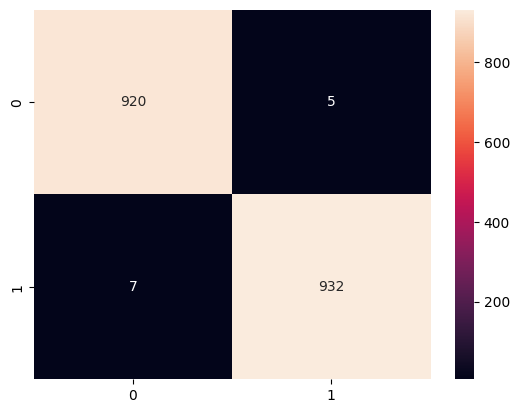

In [18]:
sk_log = experiment(LogisticRegression)

### SVM

Accuracy:  0.9914163090128756
Precision:  0.9946638207043756
Recall:  0.9883351007423118
F1:  0.9914893617021276


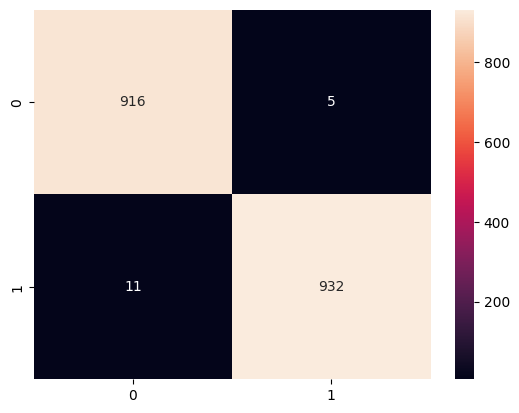

In [19]:
sk_svm = experiment(svm.SVC)

### Decision Tree

Accuracy:  0.98068669527897
Precision:  0.9818569903948773
Recall:  0.979765708200213
F1:  0.9808102345415778


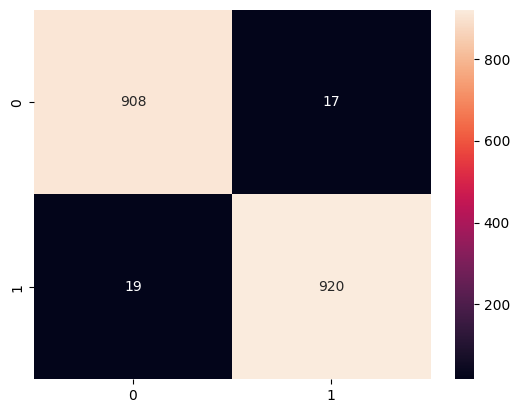

In [20]:
sk_tree = experiment(tree.DecisionTreeClassifier, max_depth=8)

### Random Forest

Accuracy:  0.9763948497854077
Precision:  0.9850586979722519
Recall:  0.968520461699895
F1:  0.9767195767195768


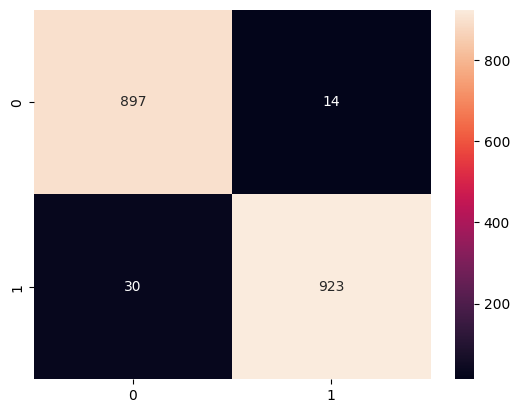

In [21]:
sk_rtree = experiment(RandomForestClassifier, max_depth=8)

Видим, что Random Forest показывает результаты хуже, чем у Decision Tree. Попробуем отказаться от бутстрапа и используем все фичи при обучении. Мы сильно просядем в скорости, но улучшим результат.

Accuracy:  0.9817596566523605
Precision:  0.9850586979722519
Recall:  0.9787910922587487
F1:  0.9819148936170212


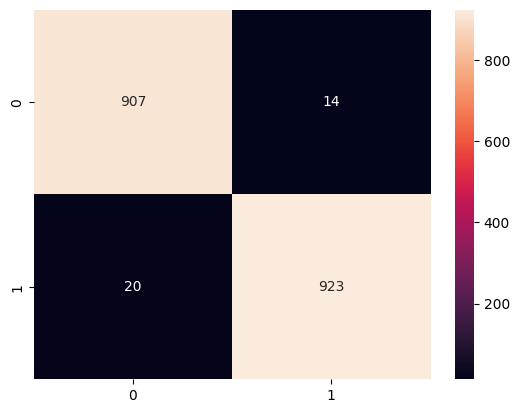

In [22]:
sk_rtree2 = experiment(RandomForestClassifier, max_depth=8, max_features=None, bootstrap=False)

### Gradient Boosting

Accuracy:  0.9881974248927039
Precision:  0.9893276414087513
Recall:  0.987220447284345
F1:  0.988272921108742


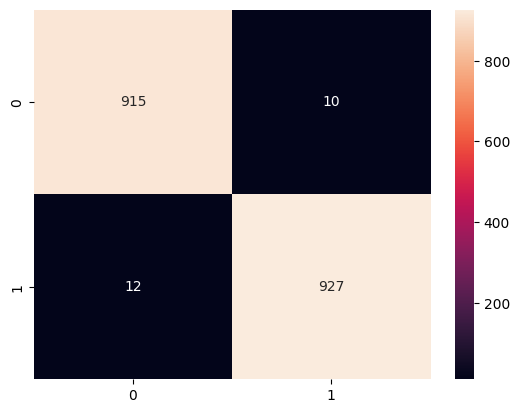

In [23]:
sk_gb = experiment(GradientBoostingClassifier, n_estimators=100, learning_rate=1.0, max_depth=1)

### LDA

Accuracy:  0.9871244635193133
Precision:  0.9978655282817502
Recall:  0.9770114942528736
F1:  0.9873284054910243


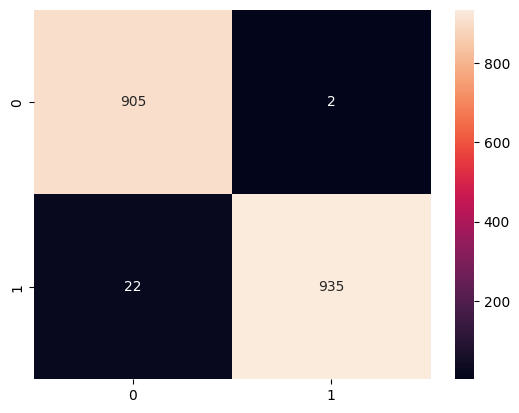

In [24]:
sk_lda = experiment(LinearDiscriminantAnalysis)

### QDA

Accuracy:  0.9785407725321889
Precision:  0.9797225186766275
Recall:  0.9776357827476039
F1:  0.9786780383795309


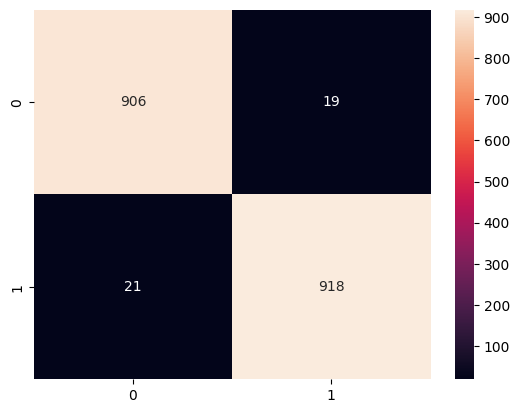

In [25]:
sk_qda = experiment(QuadraticDiscriminantAnalysis)

## Сравнение

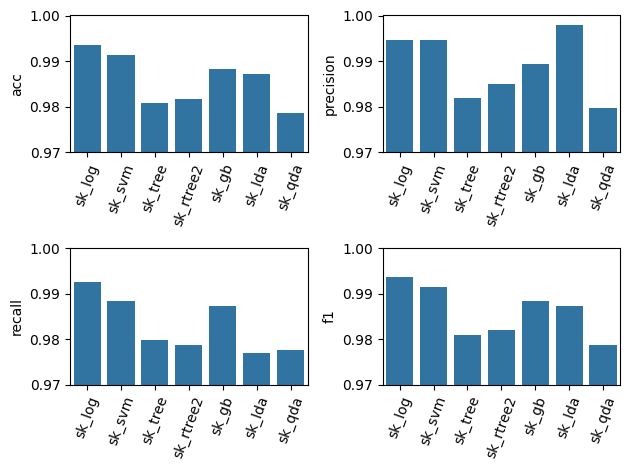

In [26]:
metrics = ['acc', 'precision', 'recall', 'f1']
names = ['sk_log', 'sk_svm', 'sk_tree', 'sk_rtree2', 'sk_gb', 'sk_lda', 'sk_qda']
methods = [sk_log, sk_svm, sk_tree, sk_rtree2, sk_gb, sk_lda, sk_qda]
fig, axs = plt.subplots(2, 2)
for k in range(len(metrics)):
    i = (k // 2) % 2
    j = k % 2
    g = sns.barplot([model[k] for model in methods], ax=axs[i, j])
    g.set_xticks(range(len(names)))
    g.set_xticklabels(names, rotation=70)
    axs[i, j].set_ylabel(metrics[k])
    axs[i, j].set_ylim(0.97, 1.0)

plt.tight_layout()
plt.show()

In [27]:
for i in range(len(methods)):
    print(names[i])
    for j in range(len(metrics)):
        print(metrics[j], ': ', methods[i][j], sep='')

sk_log
acc: 0.9935622317596566
precision: 0.9946638207043756
recall: 0.9925452609158679
f1: 0.9936034115138592
sk_svm
acc: 0.9914163090128756
precision: 0.9946638207043756
recall: 0.9883351007423118
f1: 0.9914893617021276
sk_tree
acc: 0.98068669527897
precision: 0.9818569903948773
recall: 0.979765708200213
f1: 0.9808102345415778
sk_rtree2
acc: 0.9817596566523605
precision: 0.9850586979722519
recall: 0.9787910922587487
f1: 0.9819148936170212
sk_gb
acc: 0.9881974248927039
precision: 0.9893276414087513
recall: 0.987220447284345
f1: 0.988272921108742
sk_lda
acc: 0.9871244635193133
precision: 0.9978655282817502
recall: 0.9770114942528736
f1: 0.9873284054910243
sk_qda
acc: 0.9785407725321889
precision: 0.9797225186766275
recall: 0.9776357827476039
f1: 0.9786780383795309


In [28]:
# Баланс классов
cnt = [0, 0]
for val in y:
    cnt[val] += 1
print(cnt)

[4529, 4789]


# Вывод
В результате работы можно сделать несколько выводов: лучшие результаты показала логистическая регрессия с наивысшим accuracy (0.9914), и хорошими результатами по другим метрикам. Random Forest на удивление показал плохие результаты со стандартными параметрами. Это было исправлено отказом от бутстрапа в случайном лесу и использовании всех фич при разделении.
Отдельно стоит отметить высокий показатель precision у LDA. Это может быть важно в задачах, где важно минимизировать количество ложноположительных предсказаний (FPR). QDA однако же, показала наихудшие результаты, что в теории можно улучшить подбором гиперпараметров.
Классы более менее равны, поэтому есть смысл рассматривать accuracy, однако для задачи одобрения кредита может быть важно минимизировать ложные одобрения (рассматривать precision и взять модель LDA), либо можно максимизировать количество правильно одобренных кредитов (если прибыль превзойдет убытки, и тогда рассмариваем recall). Метрика $F_1$ мне кажется не особо репрезантивной, так как не отображает разницу recall и precision у модели LDA.
